# Demo of a weighted generative model
An example weighted generative model implementation

In [52]:
# ensure that this is within the weighted_generative_model environment (and imaging space)
# import requirements
import os
import numpy as np
import scipy
import networkx as nx
import bct as bctpy
import matplotlib.pyplot as plt
# change to project directory
os.chdir('/imaging/astle/users/da04/Postdoc/weighted_gm/weighted_generative_models')

In [53]:
# set network variables
nnode = 100 # number of nodes
xnode = 5 # x axis
ynode = 5 # y axis
znode = 4 # z axis
# compute inputs
W = np.random.rand(nnode,nnode) # random network
W = W+W.T # made symmetrical
W = np.divide(W,2)
threshold, upper, lower = .9,1,0 # binarised
Atgt = np.where(W>threshold,upper,lower)
Aseed = np.zeros(nnode) # seed the seed
x = np.arange(xnode)
y = np.arange(ynode)
z = np.arange(znode)
c = np.array(np.meshgrid(x,y,z)).T.reshape(-1,3) # placed in a grid
d = scipy.spatial.distance.pdist(c)
D = scipy.spatial.distance.squareform(d) # euclidean distance matrix
m = np.count_nonzero(A) # number of connections
eta = -2 # eta parameter
gamma = .5 # gamma parameter
nparas = 1 # number of parameters
model_type = 'matching' # generative model
model_var = 'powerlaw' # wiring equation
epsilon = 1e-6

NameError: name 'G' is not defined

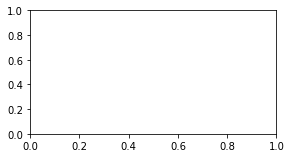

In [58]:
# visualise the model variables
# target network
Atgt = nx.Graph(Atgt)
plt.figure(figsize=(15,5))
subax1 = plt.subplot(231)
nx.draw(G,node_color='r',edge_color='k')
# visualise the seed matrix
subax2 = plt.subplot(232)
plt.imshow(Aseed)
plt.xlabel('Node')
plt.ylabel('Node')
# visualise the target matrix
subax3 = plt.subplot(233)
plt.imshow(Atgt)
plt.xlabel('Node')
plt.ylabel('Node')

In [54]:
# definition of the matching index
def matching_ind(CIJ):
    """
    For any two nodes u and v, the matching index computes the amount of
    overlap in the connection patterns of u and v. Self-connections and
    u-v connections are ignored. The matching index is a symmetric
    quantity, similar to a correlation or a dot product.

    Parameters
    ----------
    CIJ : NxN :obj:`numpy.ndarray`
        adjacency matrix

    Returns
    -------
    Min : NxN :obj:`numpy.ndarray`
        matching index for incoming connections
    Mout : NxN :obj:`numpy.ndarray`
        matching index for outgoing connections
    Mall : NxN :obj:`numpy.ndarray`
        matching index for all connections

    Notes
    -----
    Does not use self- or cross connections for comparison.
    Does not use connections that are not present in BOTH u and v.
    All output matrices are calculated for upper triangular only.
    """
    n = len(CIJ)

    Min = np.zeros((n, n))
    Mout = np.zeros((n, n))
    Mall = np.zeros((n, n))

    # compare incoming connections
    for i in range(n - 1):
        for j in range(i + 1, n):
            c1i = CIJ[:, i]
            c2i = CIJ[:, j]
            usei = np.logical_or(c1i, c2i)
            usei[i] = 0
            usei[j] = 0
            nconi = np.sum(c1i[usei]) + np.sum(c2i[usei])
            if not nconi:
                Min[i, j] = 0
            else:
                Min[i, j] = 2 * \
                    np.sum(np.logical_and(c1i[usei], c2i[usei])) / nconi

            c1o = CIJ[i, :]
            c2o = CIJ[j, :]
            useo = np.logical_or(c1o, c2o)
            useo[i] = 0
            useo[j] = 0
            ncono = np.sum(c1o[useo]) + np.sum(c2o[useo])
            if not ncono:
                Mout[i, j] = 0
            else:
                Mout[i, j] = 2 * \
                    np.sum(np.logical_and(c1o[useo], c2o[useo])) / ncono

            c1a = np.ravel((c1i, c1o))
            c2a = np.ravel((c2i, c2o))
            usea = np.logical_or(c1a, c2a)
            usea[i] = 0
            usea[i + n] = 0
            usea[j] = 0
            usea[j + n] = 0
            ncona = np.sum(c1a[usea]) + np.sum(c2a[usea])
            if not ncona:
                Mall[i, j] = 0
            else:
                Mall[i, j] = 2 * \
                    np.sum(np.logical_and(c1a[usea], c2a[usea])) / ncona

    Min = Min + Min.T
    Mout = Mout + Mout.T
    Mall = Mall + Mall.T

    return Min, Mout, Mall

In [57]:
# run the binary genreative model
mi, _, _ = matching_ind(A) # compute the matching index on the seed matrix < upadte this as struggling with zeros
Kseed = mi + mi.T # symmetrise
mseed = np.size(np.where(Aseed.flat))//2 # number of connections in the seed

array([[0.        , 0.28571429, 0.        , ..., 0.        , 0.4       ,
        0.        ],
       [0.28571429, 0.        , 0.        , ..., 0.        , 0.33333333,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.4       , 0.33333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
if type(model_var) == tuple:
    mv1, mv2 = model_var
else:
    mv1, mv2 = model_var, model_var

if mv1 in ('powerlaw', 'power_law'):
    Fd = D**eta
elif mv1 in ('exponential',):
    Fd = np.exp(eta*D)

if mv2 in ('powerlaw', 'power_law'):
    Fk = K**gamma
elif mv2 in ('exponential',):
    Fk = np.exp(gamma*K)

Ff = Fd * Fk * np.logical_not(A)
u, v = np.where(np.triu(np.ones((nnode, nnode)), 1))